# <center>Practice 05. Support Vector Machine (SVM)</center>
## <center>Part 01. Titanic EDA</center>

Повторим разведочный анализ датасета пассажиров "Титаника", который можно скачать [тут](https://www.kaggle.com/competitions/titanic/data).

Описание датасета:
- **PassengerId** ––– id пассажира, можно взять за индекс
- **Survived** (целевой признак) ––– выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass** ––– класс билета (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex** ––– пол (female или male)	
- **Age** ––– возраст в годах
- **SibSp** –––	количество братьев, сестёр (в том числе сводных) и супругов на борту	
- **Parch**	–––	количество детей и родителей на борту
- **Ticket** ––– номер билета	
- **Fare** ––– стоимость проезда пассажира	
- **Cabin** ––– номер каюты	
- **Embarked** ––– порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** выживет ли пассажир по его нецелевым признакам.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

df = pd.read_csv('../../data/titanic/titanic_train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


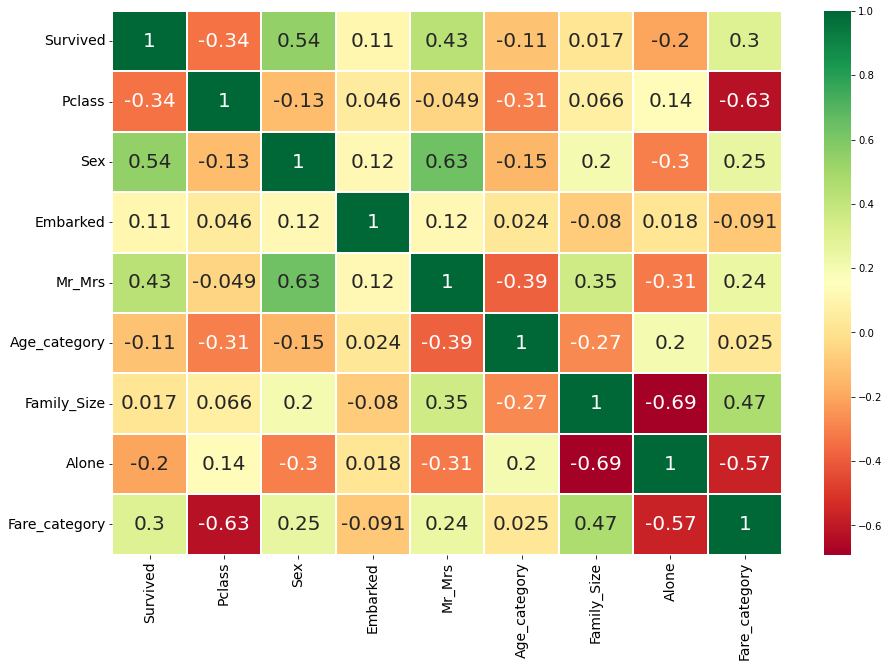

In [2]:
df['Mr_Mrs'] = 0
for i in df:
    df['Mr_Mrs']=df['Name'].str.extract('([A-Za-z]+)\.') # выделим обращения
df['Mr_Mrs'].\
replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],\
        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'], inplace=True)
df.loc[(df['Mr_Mrs'] == 'Mr') & (df['Sex'] == 'female'), "Mr_Mrs"] = 'Mrs' # исправляем обращение к доктору женщине

df.loc[(df['Age'].isnull()) & (df['Mr_Mrs'] == 'Master'), 'Age'] = 5
df.loc[(df['Age'].isnull()) & (df['Mr_Mrs'] == 'Miss'), 'Age'] = 22
df.loc[(df['Age'].isnull()) & (df['Mr_Mrs'] == 'Mr'), 'Age'] = 33
df.loc[(df['Age'].isnull()) & (df['Mr_Mrs'] == 'Mrs'), 'Age'] = 36
df.loc[(df['Age'].isnull()) & (df['Mr_Mrs'] == 'Other'), 'Age'] = 46

df['Embarked'].fillna('S', inplace=True)

df['Age_category'] = 0  # заполняем сначала значения нового признака нулями
df.loc[df['Age'] <= 16, 'Age_category'] = 0  # далле разбиваем возраста на 5 категорий
df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age_category'] = 1
df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age_category'] = 2
df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age_category'] = 3
df.loc[df['Age'] > 64, 'Age_category'] = 4

df['Family_Size'] = 0
df['Family_Size'] = df['Parch'] + df['SibSp']  # размер семьи
df['Alone'] = 0
df.loc[df['Family_Size'] == 0, 'Alone'] = 1  # путешествовал ли пассажир один

df['Fare_category'] = pd.qcut(df['Fare'], 5)
df['Fare_category'] = 0
df.loc[df['Fare'] <= 7.91, 'Fare_category'] = 0
df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare_category'] = 1
df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare_category'] = 2
df.loc[(df['Fare'] > 31) & (df['Fare'] <= 513), 'Fare_category'] = 3

df['Sex'].replace(['male', 'female'], [0, 1], inplace=True)
df['Embarked'].replace(['S', 'C', 'Q'], [0, 1, 2], inplace=True)
df['Mr_Mrs'].replace(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], [0, 1, 2, 3, 4], inplace=True)

df.drop(['Name', 'Age', 'Ticket', 'SibSp', 'Parch', 'Fare', 'Cabin', 'PassengerId'], axis=1, inplace=True)
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## <center>Part 02. SVM</center>

Support vector machines (SVMs) могут быть использованы для решения задач классификации, регрессии и обнаружения аномалий (выбросов).

Достоинствами являются:

- Эффективность для пространств больших размерностей
- Эффективность при малом размере выборки (даже меньше количества признаков)
- Эффективность по памяти, так как используют подмножество объектов из обучающей выборки (support vectors) 
- Разные ядровые переходы позволяют находить различные виды зависимостей

Недостатки:

- Напрямую не даёт вероятности принадлежности к классу 
- При количестве признаков сильно большем, чем размер обучающей выборки сложно избежать переобучения

Популярна, например, библиотека LIBSVM.

### Simple train/test split using train_test_split() + scaling

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

cols = ["Pclass","Sex","Embarked","Mr_Mrs","Age_category","Family_Size","Alone","Fare_category"] 
X = df[cols]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train = scaler.fit_transform(X_train)

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test = scaler.transform(X_test)

### First model

In [4]:
from sklearn.svm import SVC

svm = SVC(random_state=11)
svm.fit(X_train, y_train)
print("train accuracy:", svm.score(X_train, y_train))
print("test accuracy:", svm.score(X_test, y_test))

train accuracy: 0.8426966292134831
test accuracy: 0.8100558659217877


### Feature selection using SelectKBest and f_classif

f_classif оценивает насколько признак хорошо позволяет разделить объекты на нужные классы.

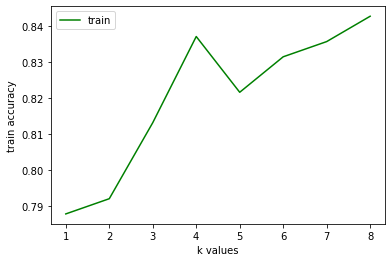

In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

accuracy_list_train = []
k = np.arange(1,9)

for i in k:
    x_new = SelectKBest(f_classif, k=i).fit_transform(X_train, y_train)
    svm.fit(x_new, y_train)
    accuracy_list_train.append(svm.score(x_new, y_train))   
    
plt.plot(k,accuracy_list_train, color="green", label="train")
plt.xlabel("k values")
plt.ylabel("train accuracy")
plt.legend()
plt.show()

### Подбор гиперпараметров с помощью GridSearchCV и StratifiedKFold

Про гиперпараметры SVC можно найти информацию тут https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svm

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
#from sklearn.metrics import accuracy_score

C = [0.1, 0.25, 0.5, 0.75, 1, 2]
kernel = ["linear", "rbf"]
gamma = ["scale", "auto", 0.0001, 0.001, 0.01, 0.1, 1]

cv = StratifiedKFold(10)

svm = SVC(random_state=11)
grid_svm = GridSearchCV(estimator=svm, cv=cv, 
        param_grid=dict(kernel=kernel,C=C, gamma=gamma))
grid_svm.fit(X_train, y_train)
print("best score: ", grid_svm.best_score_)
print("best param: ", grid_svm.best_params_)
print("test score:", grid_svm.score(X_test, y_test))
#print("test score:", accuracy_score(y_test, grid_svm.best_estimator_.predict(X_test))) # другой способ

best score:  0.8342331768388107
best param:  {'C': 0.25, 'gamma': 'scale', 'kernel': 'rbf'}
test score: 0.8268156424581006
